**Authentication**

In [2]:
from google.colab import auth
auth.authenticate_user()

**Intializing BigQuery Client**

In [3]:
from google.cloud import bigquery

project_id = 'icoads-time-series-analysis'
client = bigquery.Client(project=project_id)

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Loading the data**

In [4]:
sql = f"""
SELECT
  year,
  month,
  day,
  hour,
  latitude,
  longitude,
  indicator_for_temp,
  sea_surface_temp,
  sst_measurement_method,
  sea_level_pressure,
  wind_direction_indicator,
  wind_direction_true,
  wind_speed_indicator,
  wind_speed
FROM `icoads-time-series-analysis.icoads_data.torpedo_wharf_data`
WHERE sea_surface_temp IS NOT NULL
"""


df = client.query(sql).to_dataframe()
print('rows:', len(df))
df.head()

rows: 355906


,year,month,day,hour,latitude,longitude,indicator_for_temp,sea_surface_temp,sst_measurement_method,sea_level_pressure,wind_direction_indicator,wind_direction_true,wind_speed_indicator,wind_speed
0,2007,10,19,0.0,37.81,-122.47,0,14.1,1,1020.0,0,290,4,2.1
1,2009,6,16,0.0,37.81,-122.47,0,15.0,1,1014.7,0,250,4,6.2
2,2014,2,6,0.0,37.81,-122.47,0,11.7,1,1020.4,0,260,4,4.6
3,2006,8,4,0.0,37.81,-122.47,0,16.7,1,1010.4,0,240,4,7.2
4,2013,2,9,0.0,37.81,-122.47,0,10.6,1,1015.1,0,260,4,4.1


**Sea Surface Temperature Trend**

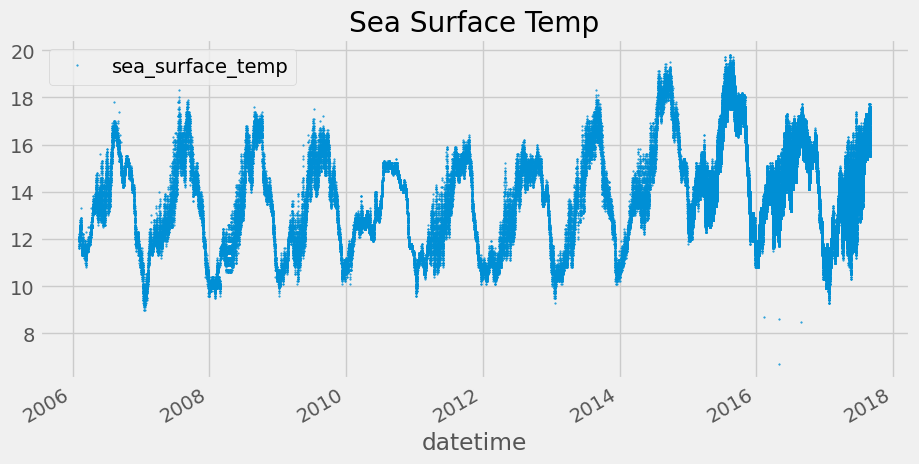

In [5]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])
df_sst = df[['datetime', 'sea_surface_temp']]
df_sst.set_index('datetime', inplace=True)
df_sst.head()
color_pal = sns.color_palette()
df_sst.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Sea Surface Temp')
plt.show()

**Creating time series features from datetime index**

In [6]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_sst, label='sea_surface_temp')
features_and_target = pd.concat([X, y], axis=1)

**Visualizing Sea Surface Temperature Weekly Trend**

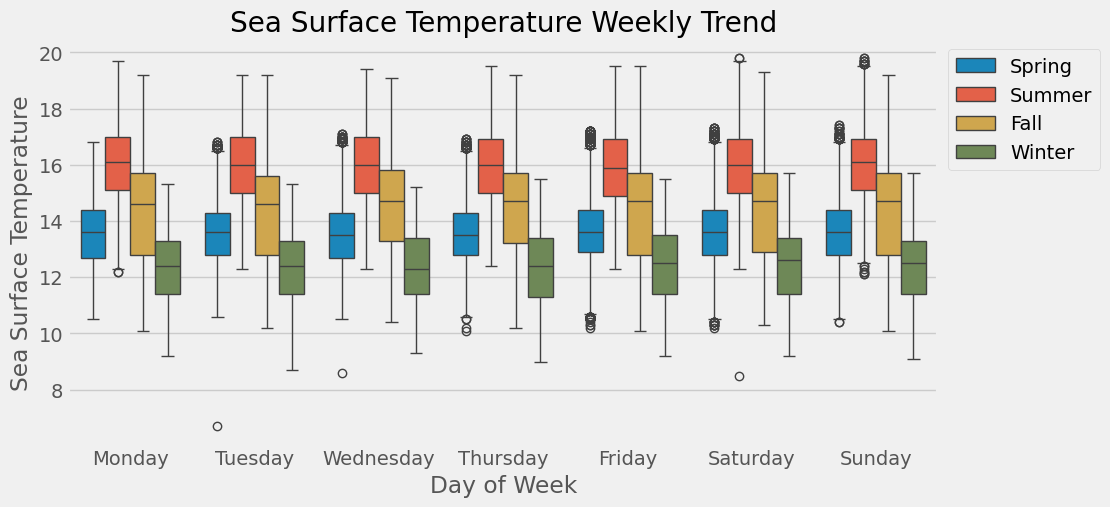

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='sea_surface_temp',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sea Surface Temperature Weekly Trend')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sea Surface Temperature')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

**Visualizing Temporal Split for Model Training and Evaluation**

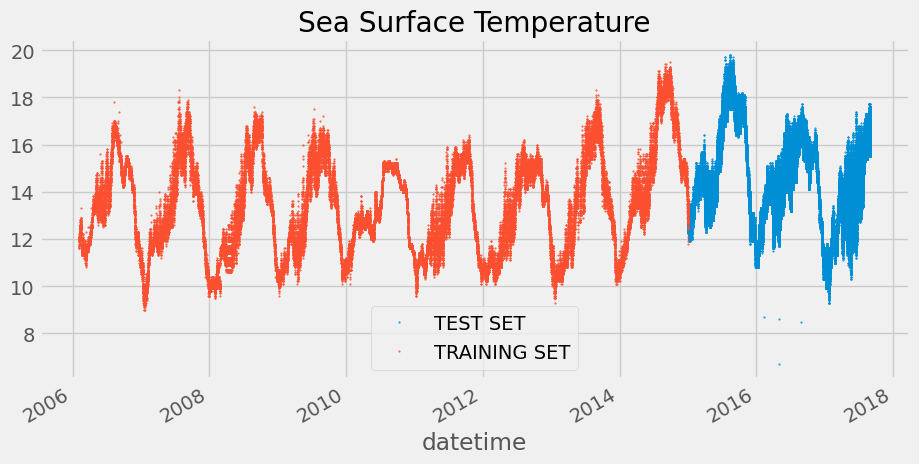

In [8]:
split_date = '1-Jan-2015'
sst_train = df_sst.loc[df_sst.index <= split_date].copy()
sst_test = df_sst.loc[df_sst.index > split_date].copy()

sst_test \
    .rename(columns={'sea_surface_temp': 'TEST SET'}) \
    .join(sst_train.rename(columns={'sea_surface_temp': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Sea Surface Temperature', style='.', ms=1)
plt.show()

**Formatting SST Data for Prophet (ds–y Structure)**

In [9]:
# Format data for prophet model using ds and y
sst_train_prophet = sst_train.reset_index() \
    .rename(columns={'datetime':'ds',
                     'sea_surface_temp':'y'})
sst_train_prophet = sst_train_prophet.drop_duplicates(subset='ds', keep='first')
sst_train_prophet['ds'] = pd.to_datetime(sst_train_prophet['ds'])
sst_train_prophet = sst_train_prophet.sort_values('ds')
full_index = pd.date_range(start=sst_train_prophet['ds'].min(),
                           end=sst_train_prophet['ds'].max(), freq='D')

sst_train_prophet = sst_train_prophet.set_index('ds').reindex(full_index)
sst_train_prophet['y'] = sst_train_prophet['y'].interpolate()
sst_train_prophet = sst_train_prophet.reset_index().rename(columns={'index': 'ds'})

**Training Prophet on Sea Surface Temperature Time Series**

In [10]:
%%time
model = Prophet()
model.fit(sst_train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphkp21mms/_erhri3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphkp21mms/yd30l9y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63314', 'data', 'file=/tmp/tmphkp21mms/_erhri3h.json', 'init=/tmp/tmphkp21mms/yd30l9y0.json', 'output', 'file=/tmp/tmphkp21mms/prophet_model0ffu23uh/prophet_model-20251210194529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 585 ms, sys: 40.9 ms, total: 626 ms
Wall time: 1.57 s


**Generating Forecasts on the Test Set**

In [12]:
sst_test_prophet = sst_test.reset_index() \
    .rename(columns={'datetime':'ds',
                     'sea_surface_temp':'y'})

sst_test_fcst = model.predict(sst_test_prophet)

In [13]:
sst_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,15.962438,12.684214,14.404965,15.962438,15.962438,-2.422463,-2.422463,-2.422463,-0.001076,-0.001076,-0.001076,-2.421387,-2.421387,-2.421387,0.0,0.0,0.0,13.539975
1,2015-01-02,15.962438,12.639505,14.475685,15.962438,15.962438,-2.422463,-2.422463,-2.422463,-0.001076,-0.001076,-0.001076,-2.421387,-2.421387,-2.421387,0.0,0.0,0.0,13.539975
2,2015-01-02,15.962438,12.698354,14.433364,15.962438,15.962438,-2.422463,-2.422463,-2.422463,-0.001076,-0.001076,-0.001076,-2.421387,-2.421387,-2.421387,0.0,0.0,0.0,13.539975
3,2015-01-02,15.962438,12.616549,14.360268,15.962438,15.962438,-2.422463,-2.422463,-2.422463,-0.001076,-0.001076,-0.001076,-2.421387,-2.421387,-2.421387,0.0,0.0,0.0,13.539975
4,2015-01-02,15.962438,12.701245,14.464408,15.962438,15.962438,-2.422463,-2.422463,-2.422463,-0.001076,-0.001076,-0.001076,-2.421387,-2.421387,-2.421387,0.0,0.0,0.0,13.539975


**Prophet Forecast Visualization for the Test Period**

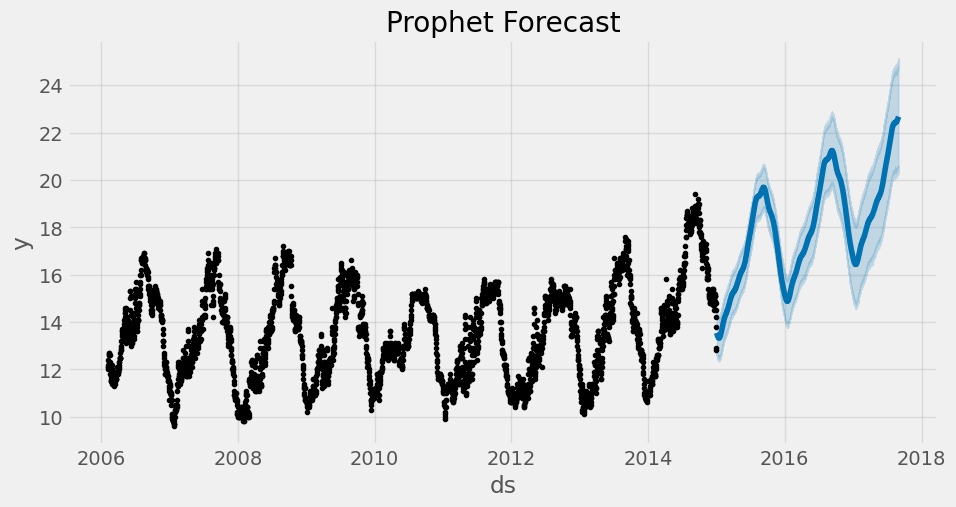

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(sst_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

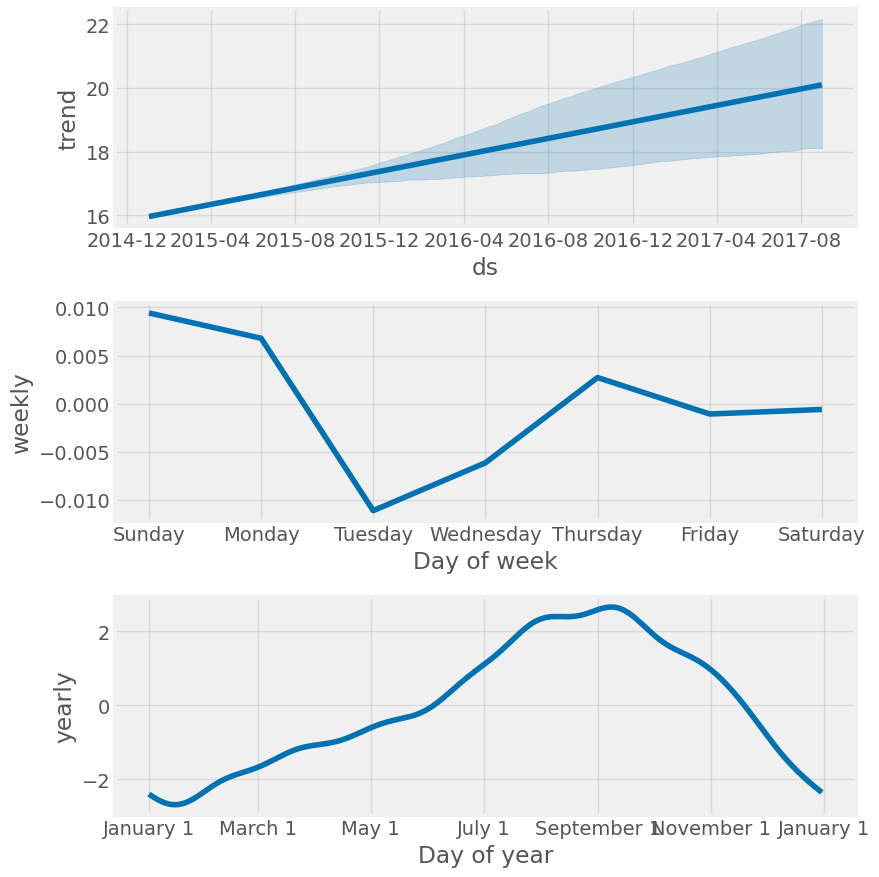

In [15]:
fig = model.plot_components(sst_test_fcst)
plt.show()

**Plot the forecast with the actuals**

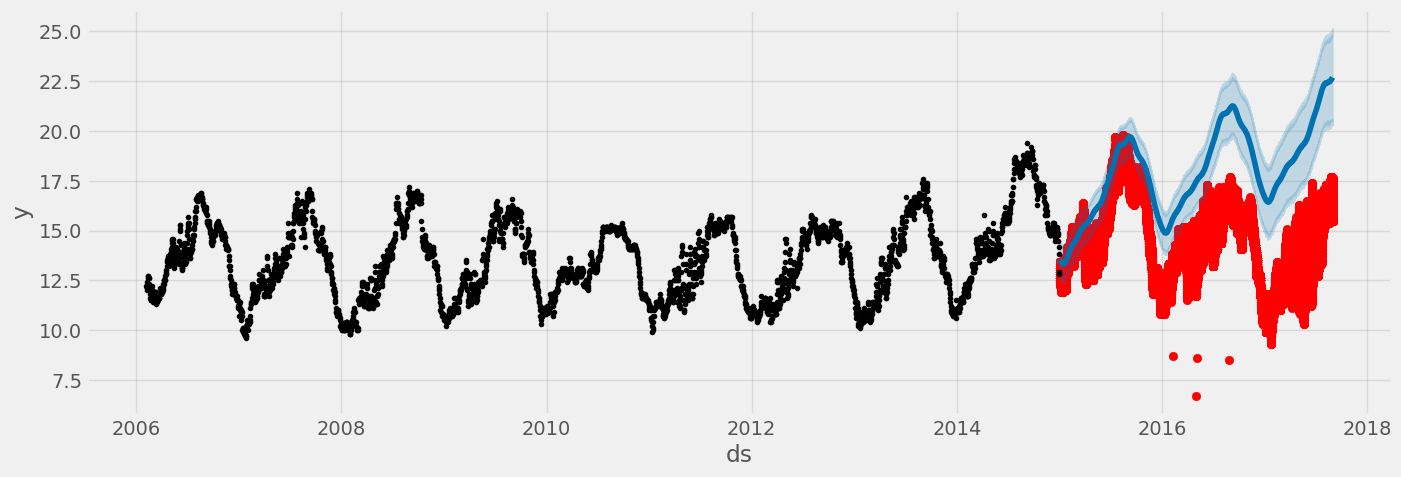

In [16]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(sst_test.index, sst_test['sea_surface_temp'], color='r')
fig = model.plot(sst_test_fcst, ax=ax)

**Error Calculation**

In [18]:
np.sqrt(mean_squared_error(y_true=sst_test['sea_surface_temp'],
                   y_pred=sst_test_fcst['yhat']))

4.517051510015073

In [19]:
mean_absolute_error(y_true=sst_test['sea_surface_temp'],
                   y_pred=sst_test_fcst['yhat'])

3.8520073049705763

In [20]:
mean_absolute_percentage_error(y_true=sst_test['sea_surface_temp'],
                   y_pred=sst_test_fcst['yhat'])

28.6881035785602